# Preparation

In [1]:
!pip install -qq twython bertopic Sastrawi

In [2]:
import gensim
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import torch

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from hdbscan import HDBSCAN
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from umap import UMAP

In [3]:
dataset = pd.read_csv("/kaggle/input/tweet-dataset/twitter-search-scraper.csv")
dataset

,avatar,fullname,id,images/0,images/1,images/2,images/3,images/4,isQuote,isReply,...,user/totalFollowing,user/totalLikes,user/totalTweets,user/url,user/userFullName,user/username,user/verified,user/website,username,verified
0,NaN,NaN,1826994226376401202,https://pbs.twimg.com/media/GVrI4CZa4AAHaM8.jpg,NaN,NaN,NaN,NaN,False,False,...,1414,38658,15914,https://twitter.com//lsangelina14,𝕷𝖔𝖚🐢🐺鍾ルイ || COMMS ON VGEN!!,@lsangelina14,False,vgen.co/LSANGELINA14,NaN,False
1,NaN,NaN,1827167972349374857,NaN,NaN,NaN,NaN,NaN,False,False,...,2943,9075,10800,https://twitter.com//lhsploopy,✩ g i a ₊˚✧,@lhsploopy,False,NaN,NaN,False
2,NaN,NaN,1826580538880385196,NaN,NaN,NaN,NaN,NaN,False,False,...,12482,72983,51387,https://twitter.com//JhonSitorus_18,Jhon Sitorus,@JhonSitorus_18,True,instagram.com/jhonsitorus8?i…,NaN,True
3,NaN,NaN,1827228761655255424,https://pbs.twimg.com/media/GVuetpYbIAAo8b3.jpg,NaN,NaN,NaN,NaN,False,False,...,389,163429,16094,https://twitter.com//_Jerung27,HiuDarat 🦈🇵🇸,@_Jerung27,False,linktr.ee/Jerung27,NaN,False
4,NaN,NaN,1826616259829793032,https://pbs.twimg.com/media/GVlxzURbgAYX9jV.jpg,NaN,NaN,NaN,NaN,False,False,...,69,602,1730,https://twitter.com//acertainmonkey,Nadir,@acertainmonkey,False,rant.xn--6ii/,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,NaN,NaN,1827004594590973970,NaN,NaN,NaN,NaN,NaN,True,False,...,299,31263,19722,https://twitter.com//itsquaileggs,️️ ️️,@itsquaileggs,True,NaN,NaN,True
467,NaN,NaN,1827232713335828739,https://pbs.twimg.com/media/GVuid9pbQAAALqk.jpg,NaN,NaN,NaN,NaN,False,False,...,192,2762,3354,https://twitter.com//Meivillexx,Mei ~ 🐰,@Meivillexx,False,NaN,NaN,False
468,NaN,NaN,1827241510775222546,NaN,NaN,NaN,NaN,NaN,False,True,...,6,26809,3432,https://twitter.com//Risa638390,Risa,@Risa638390,False,NaN,NaN,False
469,NaN,NaN,1827249587628994729,NaN,NaN,NaN,NaN,NaN,False,True,...,473,9180,4893,https://twitter.com//matchkkie,Alma🍉,@matchkkie,False,NaN,NaN,False


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 78 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   avatar                 96 non-null     object 
 1   fullname               96 non-null     object 
 2   id                     471 non-null    int64  
 3   images/0               216 non-null    object 
 4   images/1               50 non-null     object 
 5   images/2               21 non-null     object 
 6   images/3               7 non-null      object 
 7   images/4               1 non-null      object 
 8   isQuote                471 non-null    bool   
 9   isReply                471 non-null    bool   
 10  isRetweet              471 non-null    bool   
 11  likes                  471 non-null    int64  
 12  links/0                471 non-null    object 
 13  links/1                404 non-null    object 
 14  links/2                330 non-null    object 
 15  links/

# Data Preprocessing

In [5]:
def replace_slang_with_formal(text):
    kamus_alay = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")
    slang_to_formal = dict(zip(kamus_alay['slang'], kamus_alay['formal']))
    words = text.split()
    replaced_words = [slang_to_formal.get(word, word) for word in words]
    return ' '.join(replaced_words)

def clean_text_and_extract_hashtags(text):
    cleaned_text = text.replace('\n', ' ')
    hashtags = re.findall(r'#\w+', cleaned_text)
    cleaned_text = re.sub(r'#\w+', '', cleaned_text).strip()
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    hashtags_combined = ' '.join(hashtags)
    
    return cleaned_text, hashtags_combined

def remove_stop_words(tokens):
    return [word for word in tokens if word.lower() not in stop_words_set]

In [6]:
dataset['text'] = dataset['text'].apply(lambda x: replace_slang_with_formal(x))

In [7]:
dataset['cleaned_text'], dataset['hashtags'] = zip(*dataset['text'].apply(clean_text_and_extract_hashtags))

In [8]:
dataset[dataset['text'].str.contains(r'giveaway|ht|raffle', case=False, na=False)]

,avatar,fullname,id,images/0,images/1,images/2,images/3,images/4,isQuote,isReply,...,user/totalTweets,user/url,user/userFullName,user/username,user/verified,user/website,username,verified,cleaned_text,hashtags
18,NaN,NaN,1827174790530027868,NaN,NaN,NaN,NaN,NaN,False,False,...,10093,https://twitter.com//sezrotonin,🍊🍉 optimus prime,@sezrotonin,False,NaN,NaN,False,KITA ABSEN LAGI YUK JANGAN LUPA HT soalnya sud...,#KawalPutusanMK #IndonesiaEmegencyDemocracy
21,NaN,NaN,1826873301047935014,https://pbs.twimg.com/media/GVpZl71WMAAMLiy.jpg,NaN,NaN,NaN,NaN,False,False,...,8024,https://twitter.com//renpchxx,renpaichoo✨,@renpchxx,False,NaN,NaN,False,GIVEAWAY custom chibi keychain for 3 person se...,#KawalPutusanMK #TolakPilkadaAkal2an #TolakPol...
24,NaN,NaN,1826966830902280343,https://pbs.twimg.com/media/GVqwpn_W0AAemNO.jpg,https://pbs.twimg.com/media/GVqwpn_bMAAu0uw.jpg,NaN,NaN,NaN,False,False,...,385,https://twitter.com//illiosx,Lios.,@illiosx,False,x.com/MULIHAOHAO/status/1748…,NaN,False,Halo dalam rangka menaikkan HT saya mengadaka...,#kawalputusanMK #TolakPilkadaAkal2an #TolakPol...
25,NaN,NaN,1826911058474442798,https://pbs.twimg.com/media/GVp97MHboAA97Dw.jpg,NaN,NaN,NaN,NaN,False,False,...,1173,https://twitter.com//pieepie_,pipiw,@pieepie_,False,NaN,NaN,False,GIVEAWAY ALERT SALDO DANA 25K like rt postinga...,#KawalPutusanMK #TolakPilkadaAkal2an #TolakPol...
28,NaN,NaN,1827216173957583278,https://pbs.twimg.com/media/GVuTbCwWUAA8iSi.jpg,https://pbs.twimg.com/media/GVuTbMnWcAAo0Cw.jpg,https://pbs.twimg.com/media/GVuTbK0WMAA2z0D.jpg,NaN,NaN,False,False,...,2485,https://twitter.com//judikanojo,Rheia 🦜🧩,@judikanojo,False,rheiannon.carrd.co,NaN,False,ART RAFFLE INDONESIANS ONLY non followers bol...,#KawalPutusanMK #TolakPilkadaAkal2an #TolakPol...
55,NaN,NaN,1826931770987823532,https://pbs.twimg.com/media/GVqQwjjWoAA-sTy.jpg,NaN,NaN,NaN,NaN,False,False,...,45632,https://twitter.com//NESVERLAND,Rocky_Ackerman,@NESVERLAND,True,NaN,NaN,True,ini temanteman kita juga banyak yang belum di ...,#KawalPutusanMK #TolakPilkadaAkal2an #TolakPol...
56,NaN,NaN,1826943399578030129,https://pbs.twimg.com/media/GVqbVldaYAAp_du.jpg,https://pbs.twimg.com/media/GVqbVpQaUAAuvx1.jpg,NaN,NaN,NaN,False,False,...,78177,https://twitter.com//renjunampyeon,renren,@renjunampyeon,False,renjun.xn--6ii/,NaN,False,MEMANGGIL PARA KPOPERS THAIENTHU WIBU FANS BOL...,#KawalPutusanMk #TolakPilkadaAkal2an #TolakPol...
139,NaN,NaN,1826824822921593183,https://pbs.twimg.com/media/GVove_bacAAyOpW.jpg,https://pbs.twimg.com/media/GVovfkwaIAA4wFA.jpg,NaN,NaN,NaN,False,False,...,4952,https://twitter.com//vdnstrss,Vedi,@vdnstrss,False,NaN,NaN,False,GIVEAWAY Giveaway PC GG random Bayar ongkirp...,#KawalPutusanMk #TolakPilkadaAsal2an #TolakPol...
175,NaN,NaN,1827235707389419954,https://pbs.twimg.com/media/GVulL3Pa8AE9Uen.jpg,https://pbs.twimg.com/media/GVulL3Oa8AA87A0.jpg,NaN,NaN,NaN,False,False,...,16812,https://twitter.com//yanimyoo,nyan 🩷💙 GA STICKER 📌,@yanimyoo,False,NaN,NaN,False,GIVEAWAY 60pcs Silly cat sticker 2pcs Keychai...,#KawalPutusanMK #TolakPilkadaAkal2an #TolakPol...
187,NaN,NaN,1826882191772844331,https://pbs.twimg.com/media/GVpjqzgbgAMB8C4.jpg,NaN,NaN,NaN,NaN,False,False,...,1446,https://twitter.com//Artshie29,Shieshie || Art raffle📌,@Artshie29,False,NaN,NaN,False,Art raffle dalam rangka naikin ht prize nya 1 ...,#KawalPutusanMK #TolakPilkadaAkal2an #TolakPol...


In [9]:
# remove data that spam and have no relations with context of data
dataset = dataset[~dataset['text'].str.contains(r'giveaway|ht|raffle', case=False, na=False)]
dataset.reset_index(drop=True, inplace=True)

In [10]:
factory = StopWordRemoverFactory()
stop_words = factory.get_stop_words()

## Sentiment Analysis

In [11]:
pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
nlp = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [12]:
def batch_sentiment_analysis(texts):
    results = nlp(texts)
    labels = [result['label'] for result in results]
    scores = [result['score'] for result in results]
    return labels, scores

texts = dataset['cleaned_text'].tolist()
labels, scores = batch_sentiment_analysis(texts)

dataset['sentiment'] = labels
dataset['sentiment_score'] = scores

In [13]:
dataset[['cleaned_text', 'sentiment', 'sentiment_score', 'hashtags']]

,cleaned_text,sentiment,sentiment_score,hashtags
0,Kembalikan,negative,0.765483,#KEMBALIKANTEMANTEMANKAMI #kawalkeputusanMK
1,INI LUCU BANGET takut sama mahasiswa takut sam...,negative,0.999399,#KawalKeputusanMK #IndonesiaEmegencyDemocracy
2,Tambahan amunisi baru dari anakanak SMK Daripa...,negative,0.998809,#kawalkeputusanMK
3,Sudah waktunya bangun,neutral,0.772613,#KawalKeputusanMK
4,MONYET ANJING KALAJENGKING BRONTOSAURUS KONTOL...,negative,0.997181,#kawalkeputusanMK #KawalDemokrasiIndonesia
...,...,...,...,...
437,TETAP KAWAL SAMPAI TUNTAS,negative,0.998888,#kawalkeputusanMK #kawaldemokrasi
438,Terjemahan Jokowi TIDAK Ikuti Putusan MK Terka...,negative,0.991467,#KawalPutusanMK #TolakPilkadaAkal2an #TolakPol...
439,Smga lekas membaik kakak nya,neutral,0.982852,#kawaldemokrasi #TolakPolitisDinasti
440,jahat banget,negative,0.999316,#MenjagaPutusanMK #KawalPutusanMK #TolakPilkad...


## Topic Modelling

In [14]:
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.2, metric='cosine', random_state=42)
cluster_model = KMeans(n_clusters=20)
vectorizer_model = CountVectorizer(stop_words=stop_words)
representation_model = MaximalMarginalRelevance(diversity=0.3)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
def calculate_coherence_score(documents, n_topics):
    # Train BERTopic model
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=KMeans(n_clusters=n_topics),
        vectorizer_model=vectorizer_model,
        nr_topics=n_topics
    )
    
    # Get topics and probabilities
    topics, _ = topic_model.fit_transform(documents)
    
    # Extract topics in a format compatible with Gensim
    topics_words = topic_model.get_topic_info()  # Get topic info
    topics_words = [list(topic_model.get_topic(topic_id)) for topic_id in range(n_topics)]
    topics_words = [[word for word, _ in topic] for topic in topics_words]

    # Tokenize texts
    tokenized_texts = [doc.split() for doc in documents]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    # Create the coherence model
    coherence_model = CoherenceModel(
        topics=topics_words,  
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return coherence_model.get_coherence()

In [16]:
# Evaluate coherence for different numbers of topics
topic_ranges = range(5, 21)  # From 5 to 20
coherence_scores = {}

for n_topics in topic_ranges:
    score = calculate_coherence_score(dataset['cleaned_text'], n_topics)
    coherence_scores[n_topics] = score
    print(f"Number of topics: {n_topics}, Coherence Score: {score}")

# Find the number of topics with the highest coherence score
optimal_n_topics = max(coherence_scores, key=coherence_scores.get)
print(f"Optimal number of topics: {optimal_n_topics}")

Number of topics: 5, Coherence Score: 0.43543179961968725
Number of topics: 6, Coherence Score: 0.42707682499668653
Number of topics: 7, Coherence Score: 0.38133477222297746
Number of topics: 8, Coherence Score: 0.4126498696288021
Number of topics: 9, Coherence Score: 0.3549043931338196
Number of topics: 10, Coherence Score: 0.35650749092666617
Number of topics: 11, Coherence Score: 0.3591972580828966
Number of topics: 12, Coherence Score: 0.3560260298492542
Number of topics: 13, Coherence Score: 0.3883405921009953
Number of topics: 14, Coherence Score: 0.3904033768681801
Number of topics: 15, Coherence Score: 0.39530720346336745
Number of topics: 16, Coherence Score: 0.3866056433894171
Number of topics: 17, Coherence Score: 0.3909781428650035
Number of topics: 18, Coherence Score: 0.37356537349596347
Number of topics: 19, Coherence Score: 0.3913752776908487
Number of topics: 20, Coherence Score: 0.3786376425113154
Optimal number of topics: 5


In [17]:
cluster_model = KMeans(n_clusters=6)
ctfidf_model = ClassTfidfTransformer()

topic_model = BERTopic(
  embedding_model=embedding_model,           # Step 1 - Extract embeddings
  umap_model=umap_model,                     # Step 2 - Reduce dimensionality
  hdbscan_model=cluster_model,               # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,         # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                 # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
)

In [18]:
embeddings = embedding_model.encode(dataset['cleaned_text'])
topics, _ = topic_model.fit_transform(dataset['cleaned_text'], embeddings)

dataset['topic'] = topics

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [189]:
topic_df = topic_model.get_topic_info()
topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,0,123,0_terus_jangan_batalkan_kasih,"[terus, jangan, batalkan, kasih, sih, hati, ma...",[Selamat pagi selamat hari Sabtu Jangan lupa t...
1,1,82,1_demokrasi_kekerasan_konstitusi_mahasiswa,"[demokrasi, kekerasan, konstitusi, mahasiswa, ...",[KAMI MENGECAM KERAS TINDAK KEKERASAN DAN REPR...
2,2,78,2_kembalikan_rakyat_donasi_pendaftaran,"[kembalikan, rakyat, donasi, pendaftaran, calo...","[KEMBALIKAN TEMANTEMAN KAMI, KEMBALIKAN TEMANT..."
3,3,68,3_kembalikan_temanteman_metro_divhumas_polri,"[kembalikan, temanteman, metro, divhumas_polri...","[KITA KAWAL TERUS SAMPAI MENANG, 301 TEMAN KIT..."
4,4,56,4_indonesia_hidup_panjang_rakyat,"[indonesia, hidup, panjang, rakyat, jangan, jo...",[LAWAN JANGAN LENGAH BATALKAN BUKAN TUNDA PANJ...
5,5,35,5_panjang_perjuangan_batalkan_tetap,"[panjang, perjuangan, batalkan, tetap, lawan, ...",[BATALKAN BUKAN TUNDA PANJANG UMUR PERJUA...


## Explanatory Data Analysis

In [20]:
topic_model.visualize_topics()

In [ ]:
topics_time = topic_model.topics_over_time(dataset['cleaned_text'], dataset['timestamp'])

In [196]:
topic_model.visualize_topics_over_time(topics_time)

In [21]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(dataset['cleaned_text'], reduced_embeddings=reduced_embeddings)

In [22]:
topic_model.visualize_barchart()

In [200]:
top_docs = dataset.groupby('topic').apply(
    lambda x: x.nlargest(5, 'likes')
).reset_index(drop=True)

# Menampilkan hasil
topics = top_docs['topic'].unique()
for topic in topics:
    print(f"Top 5 documents for topic '{topic}':")
    docs = top_docs[top_docs['topic'] == topic]
    print(docs[['text', 'likes']])
    print("\n")

Top 5 documents for topic '0':
                                                text   likes
0  Reza Rahadian ini sudah kayak dolby atmos: All...  174464
1  awak media core selama aksi #KawalPutusanMk (g...   97238
2  “Tapi anak Pak SBY sama Bu Mega juga naik, pun...   86629
3  sumpah ini bocah ketangkep ada yang kenal gak?...   49291
4  mencari-cari sekolahnya untuk kasih hadiah ist...   47996


Top 5 documents for topic '1':
                                                text   likes
5  Ini sih yang gue salut, syukurlah pas disamper...  117885
6  INI LUCU BANGET😭 takut sama mahasiswa❎ takut s...   82197
7  Perbedaan perlakuan mahasiswa terhadap Brimob ...   75860
8  merinding banget lihat foto ini, melihat banya...   74483
9  Trisakti keras anjir.. Itu polisi yang belagu ...   48906


Top 5 documents for topic '2':
                                                 text  likes
10  Temen-temen boleh bantu share dan donasi untuk...  96406
11  KEMBALIKAN TEMAN-TEMAN KAMI #KawalDemokrasiIn

/tmp/ipykernel_36/1736859480.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [179]:
def plot_distribution(dataset, column, title, xlabel, ylabel='Frequency', color='skyblue'):
    plt.figure(figsize=(10, 6))
    distribution = dataset[column].value_counts()
    ax = distribution.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for i, value in enumerate(distribution):
        ax.text(x=i, y=value + 1, s=f'{value}', color='red', ha='center')
    plt.xticks(rotation=0)
    plt.show()

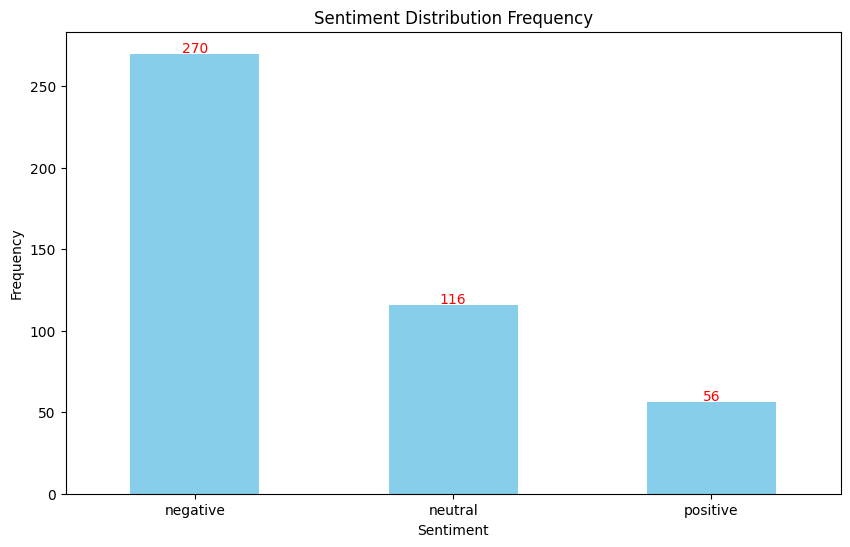

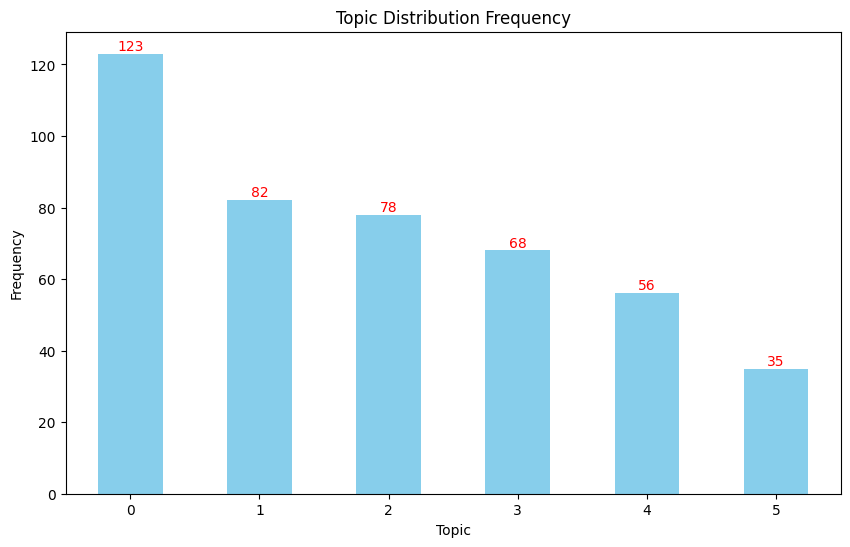

In [180]:
plot_distribution(dataset=dataset, column='sentiment', title='Sentiment Distribution Frequency', xlabel='Sentiment')
plot_distribution(dataset=dataset, column='topic', title='Topic Distribution Frequency', xlabel='Topic')

In [201]:
def plot_sentiment_by_topic(dataset, topic_col='topic', sentiment_col='sentiment'):
    sentiment_by_topic = pd.crosstab(dataset[topic_col], dataset[sentiment_col])

    custom_colors = {
        'negative': '#FF9999',  # Pastel Red
        'neutral': '#99CCFF',   # Pastel Blue
        'positive': '#99FF99'   # Pastel Green
    }

    ax = sentiment_by_topic.plot(
        kind='bar', 
        stacked=True, 
        figsize=(12, 8), 
        color=[custom_colors[col] for col in sentiment_by_topic.columns]
    )
    
    for i, topic in enumerate(sentiment_by_topic.index):
        for sentiment in sentiment_by_topic.columns:
            count = sentiment_by_topic.loc[topic, sentiment]
            if count > 0:
                ax.text(
                    x=i, 
                    y=sentiment_by_topic.loc[topic].cumsum()[sentiment] - count / 2, 
                    s=str(count), 
                    color='black', 
                    ha='center', 
                    va='center'
                )

    plt.title('Sentiment Count by Topic')
    plt.xlabel('Topic')
    plt.ylabel('Count')
    plt.legend(title='Sentiment')
    plt.xticks(rotation=0)
    
    plt.savefig('/kaggle/working/sentiment_by_topic.png')
    plt.show()

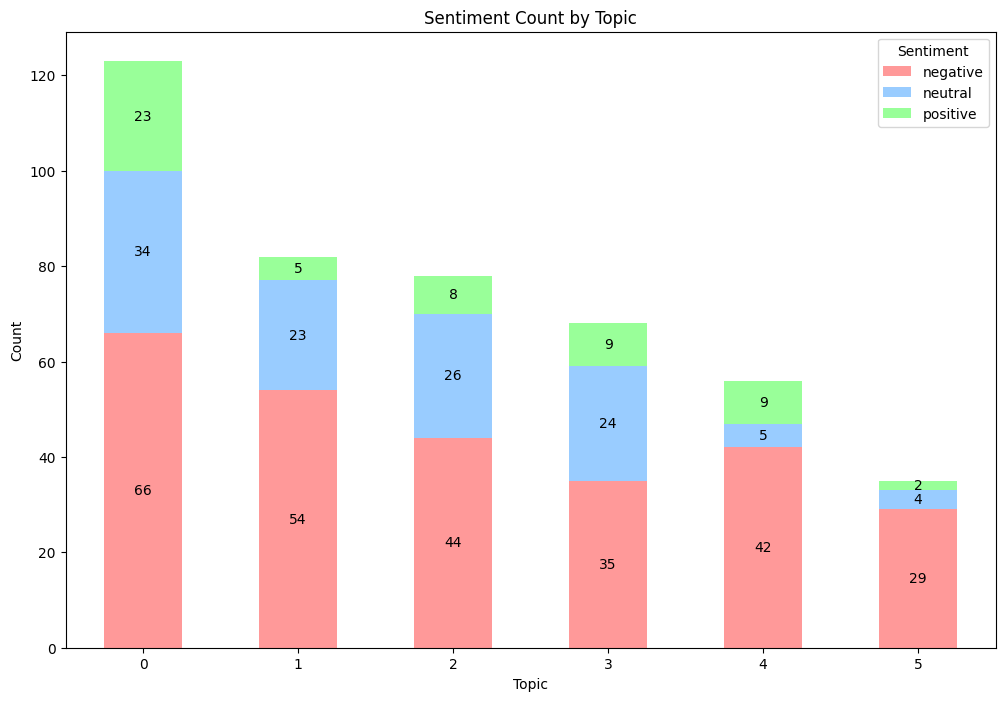

In [202]:
plot_sentiment_by_topic(dataset=dataset, topic_col='topic', sentiment_col='sentiment')

In [207]:
def plot_correlation_by_sentiment(df, x_col, y_col):
    sentiments = df['sentiment'].unique()
    num_sentiments = len(sentiments)
    
    fig, axes = plt.subplots(1, num_sentiments, figsize=(5 * num_sentiments, 6), sharey=True)
    
    if num_sentiments == 1:
        axes = [axes]
    
    for ax, sentiment in zip(axes, sentiments):
        subset_df = df[df['sentiment'] == sentiment]
        correlation = subset_df[[x_col, y_col]].corr().iloc[0, 1]
        sns.scatterplot(x=x_col, y=y_col, data=subset_df, color='blue', alpha=0.7, ax=ax)
        sns.regplot(x=x_col, y=y_col, data=subset_df, scatter=False, color='red', ax=ax)
        ax.set_title(f'{sentiment}\nCorrelation: {correlation:.2f}')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.grid(True)
    
    plt.tight_layout()
    
    plt.savefig(f"/kaggle/working/plot_correlation_by_sentiment_{y_col}.png")
    plt.show()
    

def plot_jitter(df, metrics, col):
    plt.figure(figsize=(15, 10))
    long_df = pd.melt(df, id_vars=[col], value_vars=metrics,
                      var_name='Metric', value_name='Value')
    
    sns.stripplot(x='Metric', y='Value', hue=col, data=long_df, palette='Set2', jitter=True, dodge=True)
    plt.title(f"Jitter Plot of Metrics by {col}")
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.legend(title=f"{col}")
    plt.grid(True)
    
    plt.savefig(f"/kaggle/working/sentiment_by_topic.png")
    plt.show()

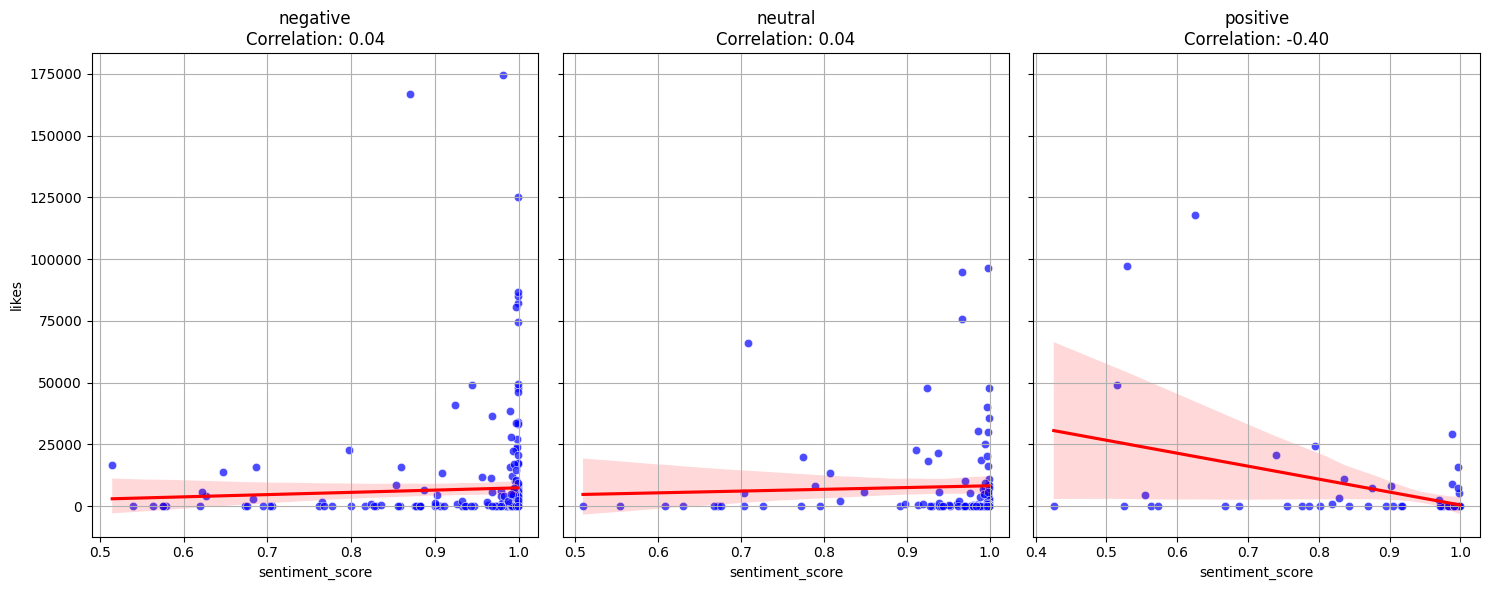

In [208]:
plot_correlation_by_sentiment(dataset, 'sentiment_score', 'likes')

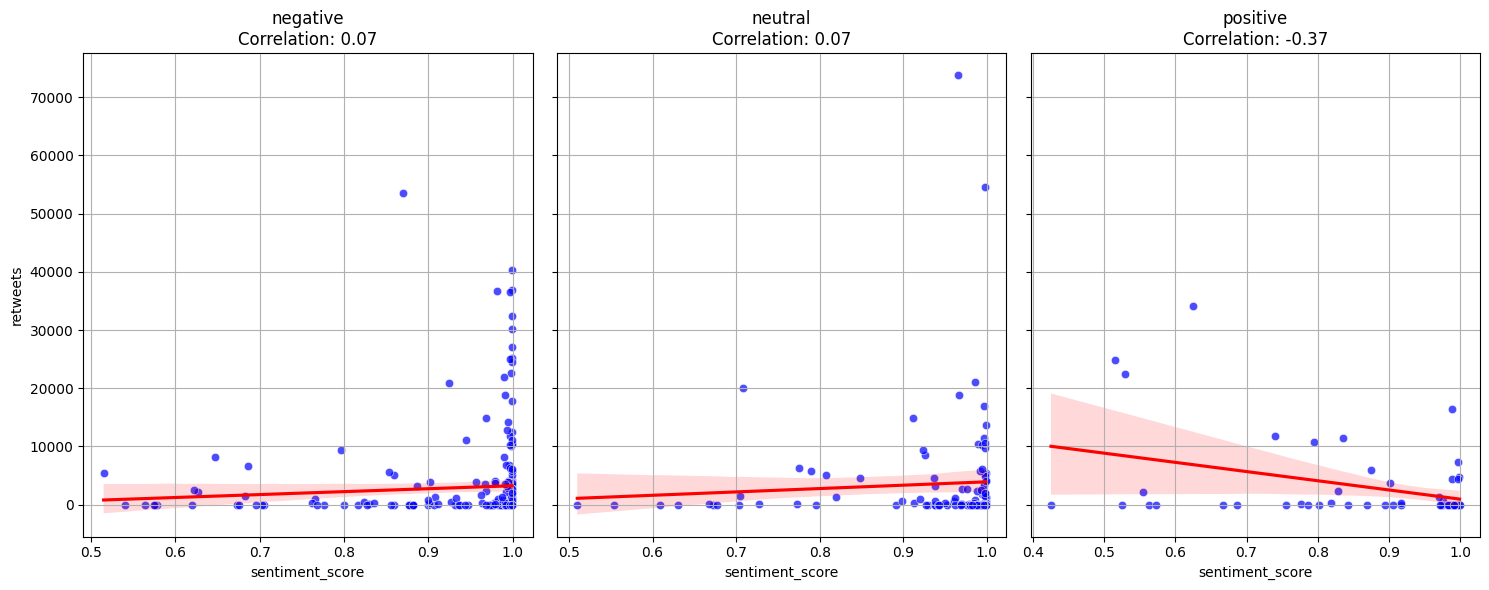

In [209]:
plot_correlation_by_sentiment(dataset, 'sentiment_score', 'retweets')

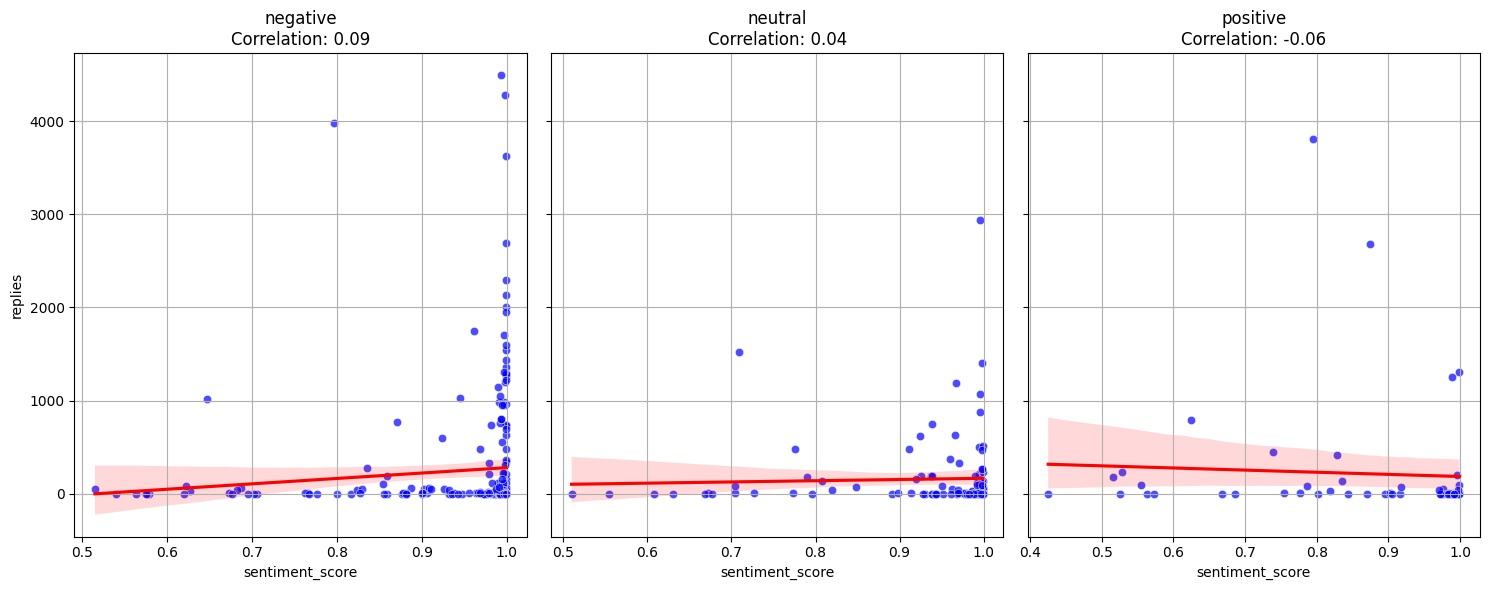

In [210]:
plot_correlation_by_sentiment(dataset, 'sentiment_score', 'replies')

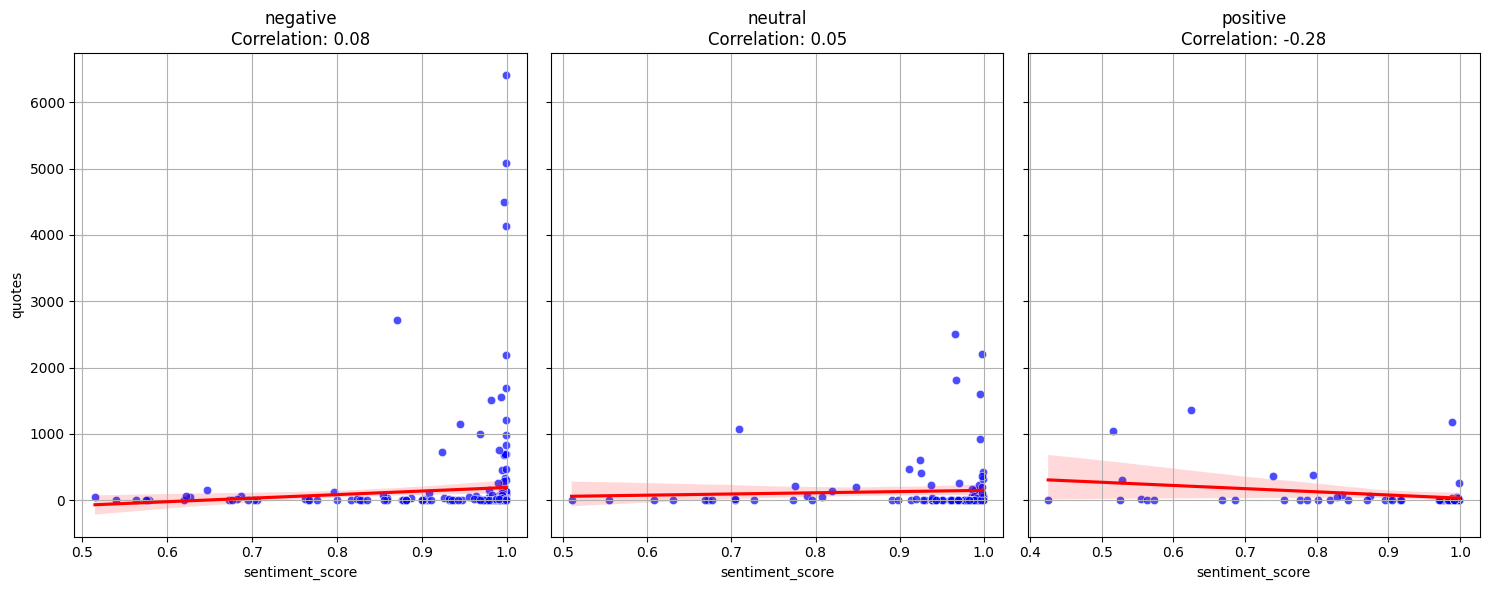

In [212]:
plot_correlation_by_sentiment(dataset, 'sentiment_score', 'quotes')

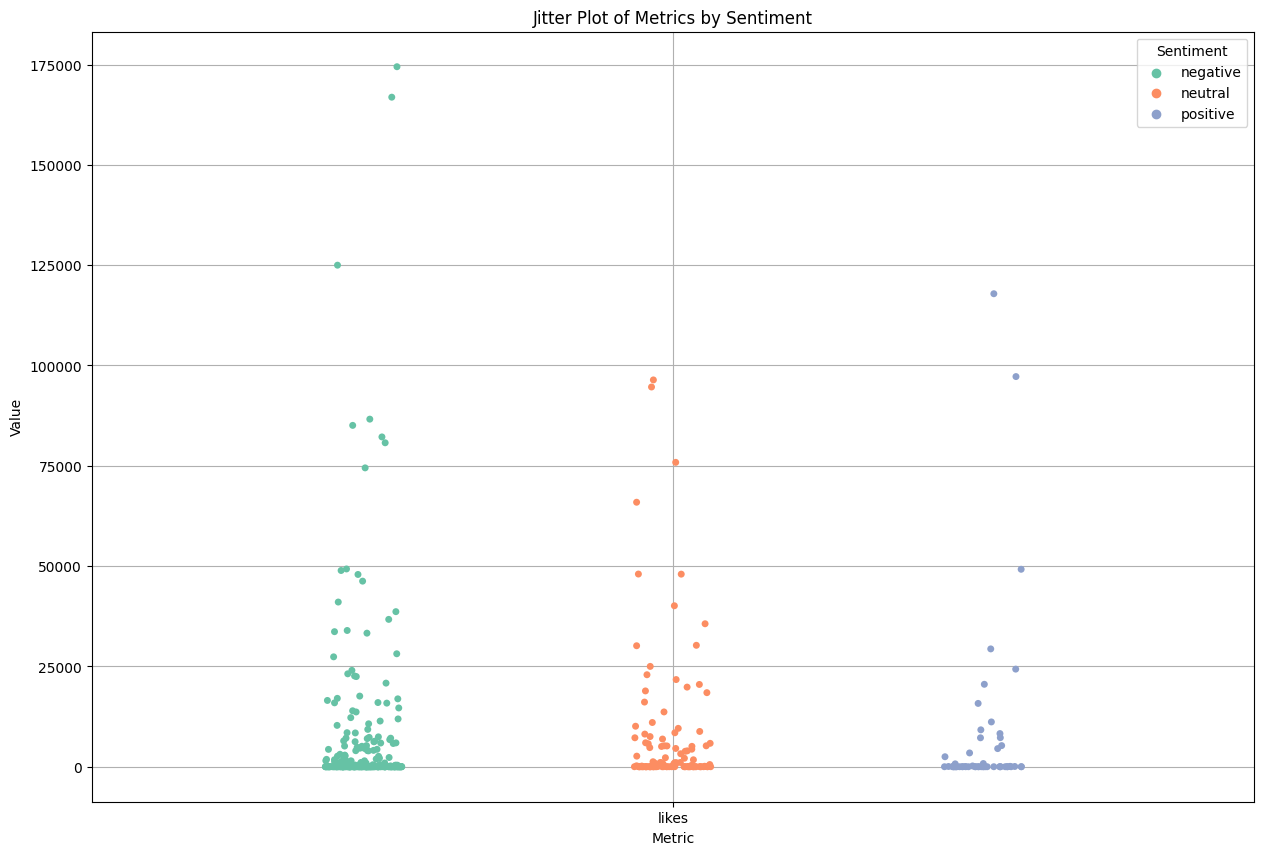

In [132]:
plot_jitter_by_sentiment(dataset, 'likes', 'sentiment')

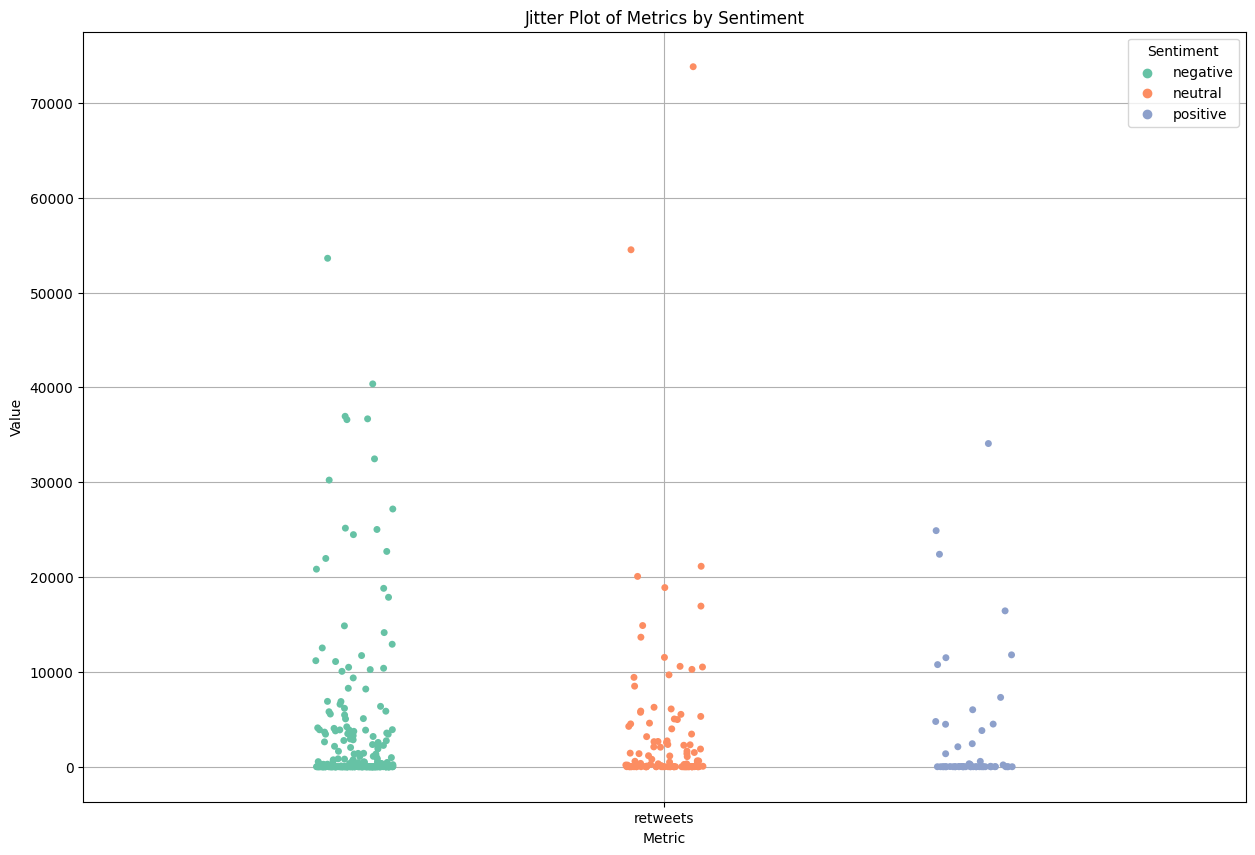

In [131]:
plot_jitter_by_sentiment(dataset, 'retweets', 'sentiment')

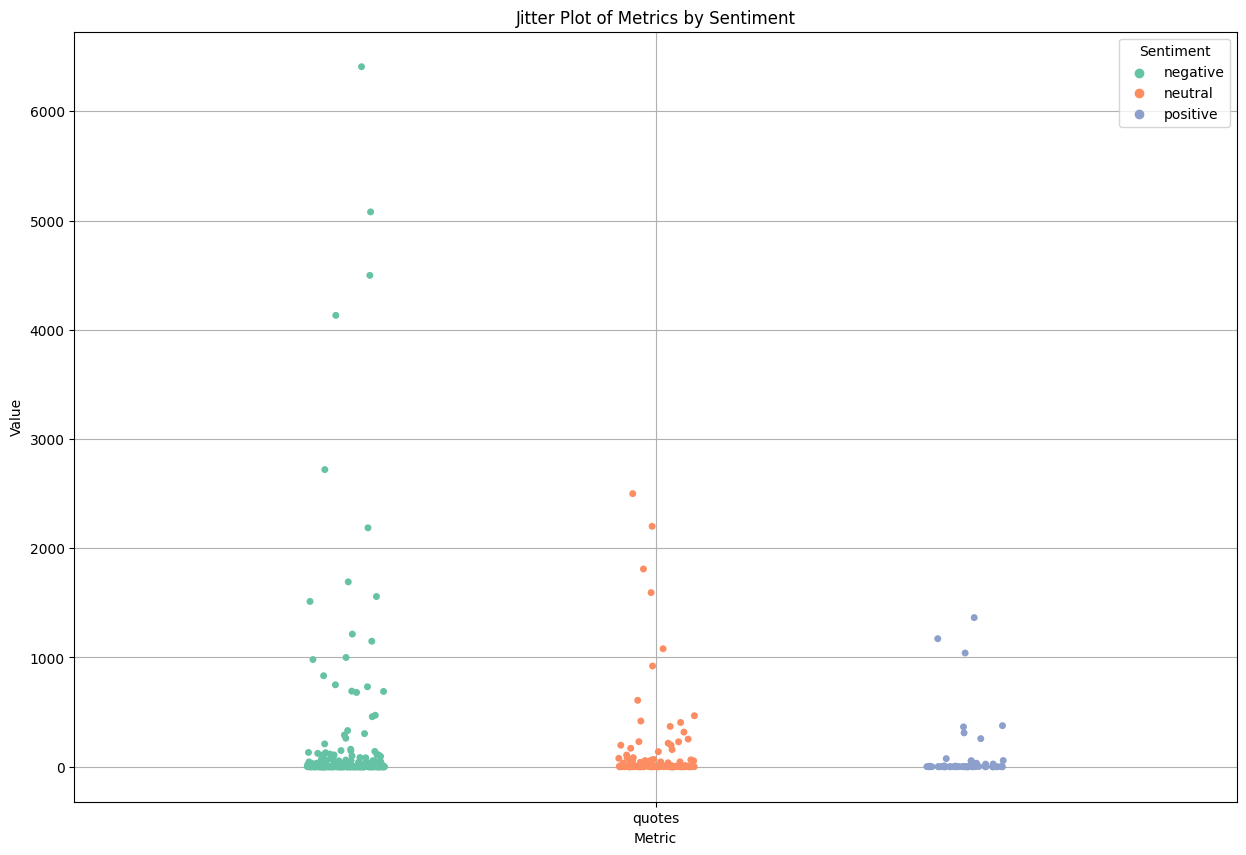

In [129]:
plot_jitter_by_sentiment(dataset, 'quotes', 'sentiment')

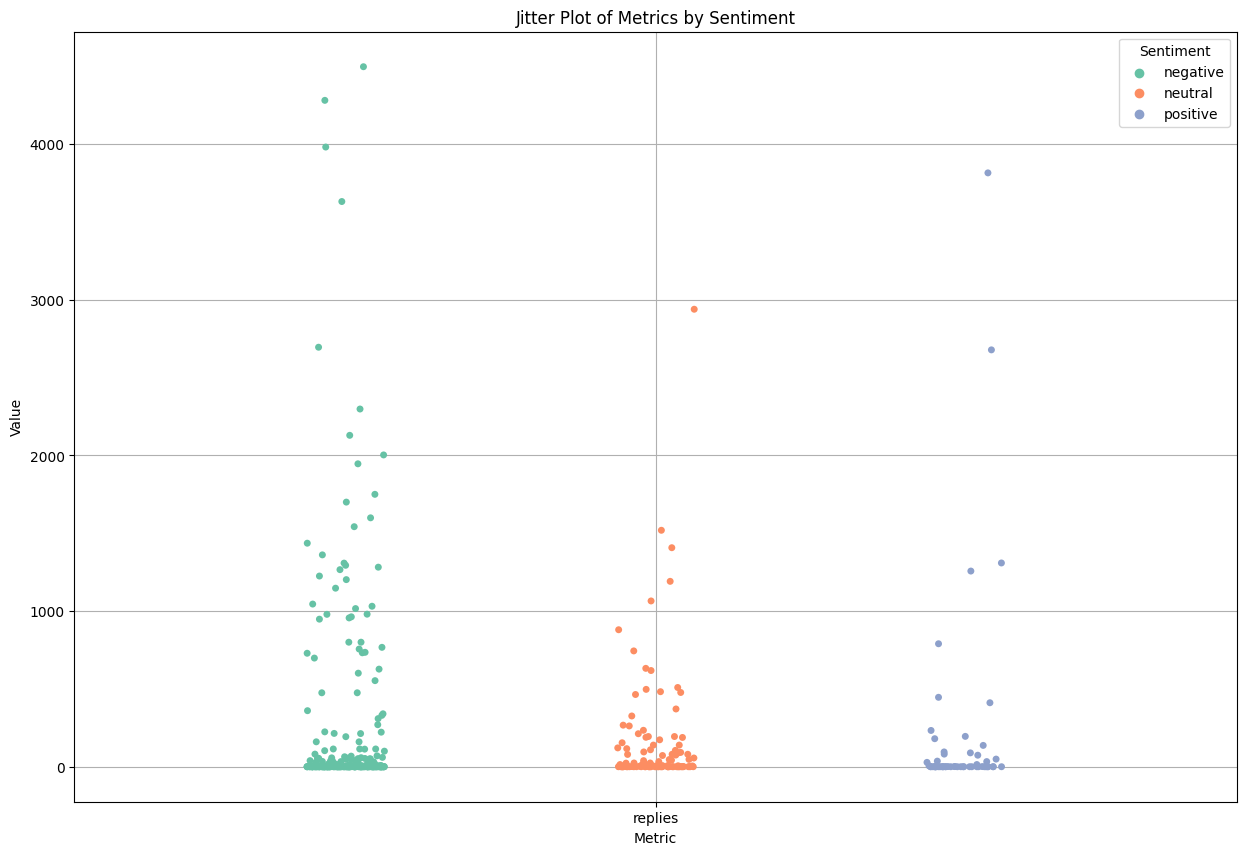

In [138]:
plot_jitter_by_sentiment(dataset, 'replies', 'sentiment')

In [174]:
summary = dataset.pivot_table(
    index=None, 
    columns='sentiment',
    values=['quotes', 'replies', 'retweets', 'sentiment_score'],
    aggfunc='describe'
)
summary

sentiment                  negative       neutral      positive
quotes          25%        0.000000      0.000000      0.000000
                50%        0.000000      5.000000      0.000000
                75%       27.000000     59.000000     24.250000
                count    270.000000    116.000000     56.000000
                max     6408.000000   2500.000000   1365.000000
                mean     164.659259    136.646552     93.964286
                min        0.000000      0.000000      0.000000
                std      683.616065    399.643368    278.977872
replies         25%        0.000000      0.000000      0.000000
                50%        0.000000      5.500000      0.000000
                75%       57.000000    117.250000     75.750000
                count    270.000000    116.000000     56.000000
                max     4497.000000   2939.000000   3815.000000
                mean     249.429630    155.913793    213.571429
                min        0.000000      0.000000      0.000000
                std      657.209404    382.137798    655.540495
retweets        25%        0.000000      0.000000      0.000000
                50%        1.000000    211.500000      0.000000
                75%     2127.250000   2837.500000   2185.500000
                count    270.000000    116.000000     56.000000
                max    53612.000000  73808.000000  34077.000000
                mean    3001.281481   3563.517241   3037.285714
                min        0.000000      0.000000      0.000000
                std     7540.914063   9318.323074   6879.635566
sentiment_score 25%        0.964542      0.938363      0.792639
                50%        0.996021      0.986800      0.970675
                75%        0.998720      0.996974      0.990994
                count    270.000000    116.000000     56.000000
                max        0.999534      0.998998      0.999025
                mean       0.950020      0.936619      0.867975
                min        0.514785      0.509801      0.425529
                std        0.098736      0.107009      0.162813

In [57]:
summary = dataset.pivot_table(
    index=None, 
    columns='topic', 
    values=['quotes', 'replies', 'retweets', 'sentiment_score'],
    aggfunc='describe
)
summary

topic                             0             1             2             3  \
quotes          25%        0.000000      0.000000      0.000000      0.000000   
                50%        0.000000      2.500000      5.000000      6.000000   
                75%        5.000000     68.000000     65.250000     56.500000   
                count    123.000000     82.000000     78.000000     68.000000   
                max     2187.000000   5079.000000   2201.000000   4498.000000   
                mean      89.081301    194.658537    120.115385    216.073529   
                min        0.000000      0.000000      0.000000      0.000000   
                std      321.342894    645.728438    321.708991    668.414460   
replies         25%        0.000000      0.000000      0.000000      0.000000   
                50%        0.000000      4.000000      5.500000      6.500000   
                75%       10.500000    154.750000    207.750000    219.000000   
                count    123.000000     82.000000     78.000000     68.000000   
                max     1542.000000   2298.000000   4497.000000   2939.000000   
                mean      99.634146    211.365854    409.064103    284.058824   
                min        0.000000      0.000000      0.000000      0.000000   
                std      290.275654    433.574620    985.688254    544.488995   
retweets        25%        0.000000      0.000000      0.000000      0.000000   
                50%        0.000000    284.500000    303.500000    218.000000   
                75%      523.500000   3969.250000   4383.000000   2490.250000   
                count    123.000000     82.000000     78.000000     68.000000   
                max    36680.000000  34077.000000  54508.000000  73808.000000   
                mean    2011.569106   3655.414634   4364.615385   4416.955882   
                min        0.000000      0.000000      0.000000      0.000000   
                std     5816.591860   6935.091659   8985.024976  11084.075159   
sentiment_score 25%        0.904271      0.987195      0.955031      0.938363   
                50%        0.990680      0.996668      0.990768      0.989023   
                75%        0.997870      0.998703      0.998649      0.997411   
                count    123.000000     82.000000     78.000000     68.000000   
                max        0.999404      0.999534      0.999516      0.999247   
                mean       0.922375      0.965459      0.942080      0.937128   
                min        0.509801      0.525212      0.514785      0.425529   
                std        0.127096      0.089763      0.105819      0.118366   

topic                             4             5  
quotes          25%        0.000000      0.000000  
                50%        0.000000      0.000000  
                75%       22.500000      0.500000  
                count     56.000000     35.000000  
                max     4132.000000   6408.000000  
                mean     141.428571    190.571429  
                min        0.000000      0.000000  
                std      653.279443   1082.183204  
replies         25%        0.000000      0.000000  
                50%        0.000000      0.000000  
                75%       54.750000      1.000000  
                count     56.000000     35.000000  
                max     2695.000000   3631.000000  
                mean     218.053571    124.885714  
                min        0.000000      0.000000  
                std      590.627353    613.301469  
retweets        25%        0.000000      0.000000  
                50%        0.500000      0.000000  
                75%     1954.250000     88.000000  
                count     56.000000     35.000000  
                max    53612.000000  36949.000000  
                mean    2807.500000   1389.200000  
                min        0.000000      0.000000  
                std     8077.626476   6260.766279  
sentiment_score 25%       